# Install & Imports

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path

import arff
import os
import re

import numpy as np
import pandas as pd
from typing import Dict, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Config: paths, constants, and display options

In [2]:
@dataclass(frozen=True)
class Config:
    """
    Centralized configuration for paths and constants.
    Update BASE_DIR to match your local project layout if needed.
    """
    # Project root where the extracted zip lives
    BASE_DIR: Path = Path("data_challenge")

    # Subfolders
    DATA_SUBDIR: str = "data"
    DIM_SUBDIR: str  = "dimension"
    OUT_SUBDIR: str  = "outputs"
    FIG_SUBDIR: str  = "outputs/figures"

    # Pre/Post split rule: pre <= (CUTOFF_YEAR, CUTOFF_QUARTER), post >= next quarter
    CUTOFF_YEAR: int = 2020
    CUTOFF_QUARTER: int = 1

    # File patterns
    ARFF_GLOB: str = "*.arff"

    # Data quality thresholds (can be tuned later)
    MISSING_COL_DROP_THRESHOLD: float = 0.70  # drop indicators if >70% missing (used later)

    # Known column names (these may be present in ARFFs)
    COUNTRY_COL: str = "country"
    SECTOR_COL:  str = "sector"

cfg = Config()

# Derived paths
DATA_DIR = cfg.BASE_DIR / cfg.DATA_SUBDIR
DIM_DIR  = cfg.BASE_DIR / cfg.DIM_SUBDIR
OUT_DIR  = cfg.BASE_DIR / cfg.OUT_SUBDIR
FIG_DIR  = cfg.BASE_DIR / cfg.FIG_SUBDIR

# Create outputs/figures folders if they don't exist
#OUT_DIR.mkdir(parents=True, exist_ok=True)
#FIG_DIR.mkdir(parents=True, exist_ok=True)

# Nice pandas display defaults
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("Paths set:")
print(" - DATA_DIR:", DATA_DIR)
print(" - DIM_DIR :", DIM_DIR)
print(" - OUT_DIR :", OUT_DIR)
print(" - FIG_DIR :", FIG_DIR)
print(f"Pre/Post cutoff at {cfg.CUTOFF_YEAR} Q{cfg.CUTOFF_QUARTER} (pre ≤ this; post ≥ next quarter).")


Paths set:
 - DATA_DIR: data_challenge/data
 - DIM_DIR : data_challenge/dimension
 - OUT_DIR : data_challenge/outputs
 - FIG_DIR : data_challenge/outputs/figures
Pre/Post cutoff at 2020 Q1 (pre ≤ this; post ≥ next quarter).


# All Data and EDA

### Concat and Clean All Files While Checking For Violation

In [3]:
# Define ARFF reading helpers
def extract_year_quarter(relation: str) -> tuple[int, int]:
    relation = relation.strip().strip("'\"")
    parts = relation.split()
    try:
        if len(parts) >= 2 and parts[1].upper().startswith("Q"):
            return int(parts[0]), int(parts[1][1:])
    except (ValueError, IndexError):
        raise ValueError(f"Invalid ARFF relation format: {relation}")


def assign_period(year: int, quarter: int, cutoff_year: int = 2020, cutoff_quarter: int = 1) -> str:
    return "pre" if (year < cutoff_year or (year == cutoff_year and quarter <= cutoff_quarter)) else "post"

def check_violation(df_object: pd.DataFrame, attr_df: pd.DataFrame) -> None:

    for _, row in attr_df.iterrows():
        name = row["name"]
        meta = row["type_raw"]  
        allowed_set = {str(t).strip() for t in meta}

        if name != 'S':
            s = df_object[name].astype("string").str.strip("'")
            mask_bad = ~s.isin(allowed_set)
        else:
            s = pd.to_numeric(df_object['S'], errors='coerce')
            mask_bad = df_object['S'].notna() & s.isna()

        if mask_bad.any():
            print(f"Violations for {name} with type {meta}: {s[mask_bad].value_counts().to_dict()}")
        

def load_arff_file(filepath: Path) -> pd.DataFrame:
    with open(filepath, "r") as f:
        lines = f.readlines()

    # Attribute names
    attr_lines = [line for line in lines if line.lower().startswith("@attribute")]

    attr_names = []
    attr_types = []

    for line in attr_lines:
        parts = line.strip().split(maxsplit=2)  # only split into 3 parts
        if len(parts) < 3:
            continue  # skip malformed lines
        attr_names.append(parts[1])
        type_str = parts[2].strip()

        if type_str.startswith("{") and type_str.endswith("}"):
            # Convert to list
            values = [x.strip().strip("'").strip('"') for x in type_str[1:-1].split(",")]
            attr_types.append(values)
        else:
            attr_types.append(type_str)

    attr_df = pd.DataFrame({"name": attr_names, "type_raw": attr_types})
    
    # Data section
    data_start = next(i for i, line in enumerate(lines) if line.lower().strip() == "@data")
    data_lines = lines[data_start + 1 :]
    data = [line.strip().split(",") for line in data_lines if line.strip() and not line.startswith("%")]

    # DataFrame
    df = pd.DataFrame(data, columns=attr_names)

    print(f'check violation for {filepath.name}')
    check_violation(df, attr_df)

    df = df.replace(r"^\s*[mM]\s*$", np.nan, regex=True)

    # Convert numeric
    feature_cols = [col for col in df.columns if col.startswith("X")]
    df[feature_cols + ["S"]] = df[feature_cols + ["S"]].apply(pd.to_numeric, errors="coerce")
    df['S'] = pd.to_numeric(df['S'], errors='coerce').astype('Int64')

    # Metadata
    relation_line = next((line for line in lines if line.lower().startswith("@relation")), None)
    relation_str = " ".join(relation_line.split()[1:]) if relation_line else ""
    year, quarter = extract_year_quarter(relation_str)
    df["year"] = year
    df["quarter"] = quarter
    df["period"] = df.apply(lambda row: assign_period(row["year"], row["quarter"]), axis=1)

    return df

# Load and stack all ARFF files
arff_files = sorted(DATA_DIR.glob("*.arff"))
df_list = [load_arff_file(file) for file in arff_files]
df_all = pd.concat(df_list, ignore_index=True)

# Drop rows with all zero or NaN features
feature_cols = [col for col in df_all.columns if col.startswith("X")]
mask_all_zero_or_nan = df_all[feature_cols].fillna(0).eq(0).all(axis=1)
df_all = df_all.loc[~mask_all_zero_or_nan].copy()


# Fill remaining NaNs with median
display("Filling remaining NaNs with median...", df_all[feature_cols].median())
df_all[feature_cols] = df_all[feature_cols].fillna(df_all[feature_cols].median())

print("✅ All ARFF files loaded and stacked.")

check violation for 2017 Q2.arff
Violations for X44 with type string: {'0': 110, '-152': 2, '304.33': 1, '476.76': 1, '-583': 1, '63.69': 1, '159': 1, '-21168': 1, '679': 1, '17528': 1, '-215': 1, '-3501': 1, '-780': 1, '102': 1, '83': 1, '3786': 1, '222': 1, '-352': 1, '363': 1, '2376.94': 1, '-5.48': 1, '2003.24': 1, '39.85': 1, '27': 1, '417': 1, '-8619': 1, '17601.86': 1, '4286.06': 1, '-4834.88': 1, '4570': 1, '18299': 1, '75131.94': 1, '15487': 1, '138694': 1, '396142': 1, '-88477.96': 1, '-382431.45': 1, '-1888.73': 1, '2699': 1, '-931.14': 1, '60': 1, '1654': 1, '710': 1, '94440.13': 1, '1195': 1, '2031': 1, '158': 1, '848': 1, '1442.25': 1, '3440': 1, '773': 1, '103400': 1, '2688': 1, '5667': 1, '184.97': 1, '1124': 1, '-2913': 1, '2014': 1, '8942': 1, '862': 1, '-1245': 1, '3996': 1, '8962.28': 1, '1161': 1, '-615': 1, '-5102': 1, '1585': 1, '-752': 1, '-119': 1, '-27': 1, '-28971': 1, '1093.3': 1, '-3222.71': 1, '-6118.82': 1, '5363.71': 1, '-44.52': 1, '474': 1, '568': 1, '

'Filling remaining NaNs with median...'

X1    0.0000
X2    0.5100
X3    0.1300
X4    1.3600
X5    0.0200
       ...  
X78   1.0000
X79   0.9900
X80   1.0000
X81   0.0000
X82   0.0000
Length: 82, dtype: float64

✅ All ARFF files loaded and stacked.


In [4]:
# Delete Italy row as a violation
VIOLATING_COUNTRIES = ["Italy"]
df_all = df_all[~df_all["Country"].isin(VIOLATING_COUNTRIES)]

In [7]:
# Read the sector dimension table
sector_map_df = pd.read_csv("data_challenge/dimension/sector_dimension.csv")

# Create a dictionary: {code_sector: description_sector}
sector_map = dict(zip(sector_map_df["code_sector"], sector_map_df["description_sector"]))
sector_map

{1: 'Transportation and warehousing',
 2: 'Wholesale trade',
 3: 'Manufacturing',
 4: 'Retail trade',
 5: 'Energy',
 6: 'Construction'}

In [8]:
df_all["sector_name"] = df_all["S"].map(sector_map)

In [9]:
# Read the sector dimension table
sector_map_df = pd.read_csv("data_challenge/dimension/sector_dimension.csv")

# Create a dictionary: {code_sector: description_sector}
sector_map = dict(zip(sector_map_df["code_sector"], sector_map_df["description_sector"]))

# Check for any unmapped values
if df_all["sector_name"].isna().any():
    missing = df_all[df_all["sector_name"].isna()]["S"].unique()
    print("⚠️ Unmapped sector codes found:", missing)

sector_map

⚠️ Unmapped sector codes found: <IntegerArray>
[<NA>]
Length: 1, dtype: Int64


{1: 'Transportation and warehousing',
 2: 'Wholesale trade',
 3: 'Manufacturing',
 4: 'Retail trade',
 5: 'Energy',
 6: 'Construction'}

In [ ]:
df_all["sector_name"] = df_all["S"].map(sector_map)

In [ ]:
# Result
print("Shape:", df_all.shape)
print("Columns:", df_all.columns.tolist()[:10], "...")

Shape: (5883, 90)
Columns: ['Country', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'] ...


In [11]:
display(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1 to 7233
Data columns (total 88 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      5891 non-null   object 
 1   X1           5891 non-null   float64
 2   X2           5891 non-null   float64
 3   X3           5891 non-null   float64
 4   X4           5891 non-null   float64
 5   X5           5891 non-null   float64
 6   X6           5891 non-null   float64
 7   X7           5891 non-null   float64
 8   X8           5891 non-null   float64
 9   X9           5891 non-null   float64
 10  X10          5891 non-null   float64
 11  X11          5891 non-null   float64
 12  X12          5891 non-null   float64
 13  X13          5891 non-null   float64
 14  X14          5891 non-null   float64
 15  X15          5891 non-null   float64
 16  X16          5891 non-null   float64
 17  X17          5891 non-null   float64
 18  X18          5891 non-null   float64
 19  X19        

None

In [12]:
display(df_all)

,Country,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,S,year,quarter,period,sector_name
1,Poland,0.0000,0.4900,0.0600,1.3100,0.0600,0.0100,1.0600,0.1800,0.5100,0.0100,0.0500,0.0500,0.0400,0.0200,2.0600,0.0100,0.0500,0.0100,0.0200,0.4600,0.0100,2.6900,0.0700,6.2300,2.4800,0.0100,0.9600,0.3500,0.0000,0.1800,0.6900,0.8200,0.0000,0.6100,0.0400,0.1500,1.1900,0.0300,0.1600,0.4800,0.1800,0.6700,1.0700,"94,440.1300",0.0100,0.6000,8.5100,1.6800,0.9800,0.2300,0.2000,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,829.6200,"46,173.1900","15,221.7400","68,156.1700",426.1700,555.8400,1.1200,1.0900,1.0600,1.0400,13.7000,-14.8800,1.1100,1.1200,1.0400,0.0000,0.5900,1,2017,2,pre,Transportation and warehousing
2,Hungary,0.0100,0.7800,-0.0400,0.9000,0.0000,0.0100,0.2700,0.2700,0.2200,0.0100,0.0200,0.0300,-0.8100,0.0100,1.2700,0.0200,0.0300,0.0100,0.0200,0.2200,0.0100,-4.2400,-0.0600,5.8100,2.6400,0.0600,-0.0300,-0.0200,0.0000,0.0000,0.8400,0.6200,0.0000,0.3900,0.0500,0.9400,0.8900,0.0300,0.1300,0.4400,0.3800,0.3300,0.9400,"-23,622.8500",0.0200,1.8800,47.5800,1.4300,0.7100,0.4100,4.5300,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0500,-0.0500,1.1500,1.1900,1.4500,0.9200,1.1400,1.0800,1.1800,0.0000,0.0000,1,2017,2,pre,Transportation and warehousing
3,Poland,-0.0200,0.4400,0.1800,1.5200,0.2800,-0.0100,1.2900,0.2100,0.5600,-0.0200,-0.0200,-0.0400,-0.0700,-0.0200,2.2900,-0.0400,-0.0400,-0.0200,-0.0900,0.2800,-0.0400,-1.8000,0.3900,4.9700,1.7600,-0.0300,0.6700,0.5300,0.0000,0.2100,4.7400,0.6500,0.0000,0.2200,-0.0900,-0.1600,1.1700,-0.0100,-0.0500,1.2200,0.3500,1.2100,1.3900,"16,981.8200",-0.0300,0.1500,1.6900,0.6200,0.5900,0.4400,0.2700,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,"1,199.5500","-89,163.8800","-60,401.1200","-37,722.9700",675.9800,"1,446.0100",2.3400,2.0400,0.7300,0.5700,0.7400,0.8900,1.6000,0.6000,0.4800,0.0000,0.7300,1,2017,2,pre,Transportation and warehousing
6,Poland,0.0000,0.6400,0.1400,1.2300,-0.0200,0.0100,0.5600,0.9000,0.3600,0.0100,0.0200,0.0100,0.0100,0.0200,1.5600,0.0100,0.0100,0.0100,0.0000,0.3700,0.0000,1.5600,0.5900,4.1600,0.7200,0.0200,1.4500,1.3800,0.1000,0.9000,27.0700,0.3800,0.1100,0.2400,0.0100,0.0800,1.1800,0.0000,0.0000,1.1800,0.6200,1.4800,1.5900,"2,060.0000",0.0100,0.0800,30.1400,1.5400,1.4600,3.6900,0.1300,-0.1300,0.0000,-0.0200,-0.0200,-0.0300,-0.6600,-0.0300,4.9000,-0.0200,-2.3600,0.0000,0.0000,0.0000,0.0000,652.8300,"17,942.3700","8,448.2050","30,880.9900",233.7300,964.0200,1.1500,1.1600,1.0300,1.0200,0.6300,0.6900,0.4200,1.0900,1.0000,-0.3600,-0.0700,1,2017,2,pre,Transportation and warehousing
8,Poland,0.0100,0.5400,0.0800,1.2000,0.0300,0.0200,0.8600,0.3400,0.4600,0.0200,0.0400,0.0500,0.0400,0.0300,1.8600,0.0300,0.0500,0.0100,0.0300,0.4300,0.0200,9.7600,0.1600,4.3500,1.5900,0.0300,0.8400,0.6400,0.3400,0.3600,2.9900,0.5900,1.0000,0.0300,0.0400,0.0900,0.9600,0.0300,0.0900,0.9100,0.4100,0.9100,1.1600,"1,854.0000",0.0200,0.2800,3.3700,0.8900,0.8300,0.6600,-0.0500,1.1400,0.0000,0.0100,0.0200,0.0100,0.0600,0.0200,-4.9200,0.0200,0.5300,0.0000,0.0000,0.0000,0.0000,951.7300,"25,860.0000","13,858.4700","30,653.2500",439.3400,862.5800,1.1500,1.2100,1.2000,1.3400,0.7600,0.4800,1.3200,1.3700,1.3200,5.6100,-1.9000,1,2017,2,pre,Transportation and warehousing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [13]:
feature_cols = [col for col in df_all.columns if col.startswith("X")]
display(df_all[feature_cols].describe())

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82
count,"5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000","5,891.0000"
mean,-0.0369,"-31,916.3751",-4.1870,2.5493,"-1,877.7214",-0.0304,3.2036,"-30,614.9580","-73,951.2122",-0.0283,0.0980,-4.5570,0.0014,0.1052,4.1599,0.0333,-4.7898,-0.0355,-4.8388,"-72,073.4907",0.0954,-1.3417,0.9481,4.3005,53.0430,"11,650.8732",10.8465,7.8896,5.4883,"-30,783.5228",22.1655,"-105,500.5072",0.4148,0.8295,-4.9228,1.3776,1.8385,"-2,709.4612",-4.5964,1.9121,-367.0793,0.7618,1.3492,"25,653.0968","2,462.6699",0.6224,31.0727,55.2866,10.8579,15.2907,12.9770,"-635,184,182,603.5978",-0.1871,-0.0050,-0.1393,-0.0922,0.3924,-0.0982,4.0331,-0.0000,1.1626,0.0000,0.0823,0.0499,0.0000,"749,191,974.5929","38,481.2461","12,752.9548","30,514.5390","1,659.9170","10,400.7125",1.8416,3.6938,"-17,574.9447",1.5134,2.4799,1.7600,2.2633,1.8110,1.9593,"-338,700.9958",-0.9549
std,3.1362,"1,661,596.8723",602.7983,18.2526,"95,846.9687",3.1443,34.0005,"1,611,331.2254","3,847,677.8194",3.1387,5.6731,353.4421,1.6077,5.5838,34.0048,2.0817,353.2321,3.0688,352.8790,"3,751,857.2625",5.5982,919.7069,242.8103,1.2628,"2,914.7621","893,630.1547",769.6619,562.6983,413.0177,"1,621,253.2776",245.2256,"5,490,054.2420",3.8524,9.4123,358.7144,115.2834,18.1176,"145,135.4167",355.8423,17.8490,"19,195.5751",257.7843,257.9652,"161,465.4613","188,915.0437",13.1052,"1,018.4955","4,106.5152",769.6611,968.3824,688.6721,"48,752,196,102,639.7266",10.2654,0.8355,41.9697,6.3853,27.4583,6.4060,"2,181.8118",1.6422,86.3604,0.0016,6.1341,2.5410,0.0000,"57,484,117,872.7817","932,150.8019","436,650.8726","1,250,324.8263","55,901.3238","263,783.4848",36.3706,184.3051,"1,349,032.5732",21.3977,231.2986,193.5478,50.3592,25.8244,33.3595,"26,046,151.4668",109.9248
min,-233.2600,"-116,587,712.3000","-32,104.3500",-0.4300,"-6,654,070.5000",-233.2600,-1.0000,"-113,917,459.0000","-269,613,078.2000",-233.2600,-83.0600,"-26,941.0000",-22.0800,-44.8100,0.0000,-18.9900,"-26,941.0000",-233.2600,"-26,949.0000","-262,959,007.7000",-34.4400,"-34,743.0000","-17,355.6100",-0.8500,"-4,304.3600",-202.1900,-110.7600,-74.4700,-197.6500,"-114,655,889.8000",-17.8900,"-384,863,587.0000",-230.4100,-94.6100,"-27,373.0000","-6,366.5000",-94.6100,"-10,402,188.3300","-27,140.0000",-0.4200,"-1,337,203.5000","-17,872.6300","-17,869.9200","-1,249,604.0000",-551.8000,-216.2900,"-2,953.4700",-430.3300,-110.7600,-300.2600,"-7,959.3700","-3,741,870,000,000,000.0000",-509.4500,-59.6600,"-2,452.5200",-482.7900,-592.0700,-482.7900,"-140,961.2000",-88.1600,"-3,215.3600",-0.0600,-0.0800,-75.3400,0.0000,"-1,917,336.6700","-11,061,142.8600","-16,343,490.3000","-15,292,307.6900",0.0000,0.0000,-94.5000,-272.4000,"-103,542,093.5000",-4.1900,"-10,459.9000","-3,09

In [14]:
df_all.groupby("sector_name")[feature_cols].describe()[["X1", "X2"]]

X1                                                                X2  \
                                    count    mean    std       min     25%    50%    75%     max      count   
sector_name                                                                                                   
Construction                     788.0000  0.0047 0.0424   -0.4800  0.0000 0.0000 0.0100  0.2200   788.0000   
Energy                           195.0000 -0.0094 0.0960   -0.7000  0.0000 0.0000 0.0100  0.5100   195.0000   
Manufacturing                  3,274.0000 -0.0078 0.4462  -15.7900  0.0000 0.0000 0.0100 13.4900 3,274.0000   
Retail trade                     645.0000 -0.0045 0.1261   -1.8200 -0.0100 0.0000 0.0200  0.9700   645.0000   
Transportation and warehousing   185.0000  0.0112 0.0697   -0.4500  0.0000 0.0000 0.0200  0.4600   185.0000   
Wholesale trade                  796.0000 -0.2420 8.4844 -233.2600 -0.0100 0.0100 0.0200 52.3500   796.0000   

                                                                                                                
                                        mean            std               min    25%    50%    75%         max  
sector_name                                                                                                     
Construction                          0.6271         1.0496            0.0000 0.4300 0.5800 0.7300     29.0500  
Energy                                0.9779         2.5014            0.0000 0.3950 0.5000 0.5700     17.9900  
Manufacturing                         7.7886       414.3161            0.0000 0.3400 0.5100 0.5900 23,707.1400  
Retail trade                   -291,545.6175 5,017,500.6795 -116,587,712.3000 0.3700 0.5400 0.7100      7.5700  
Transportation and warehousing        0.5692         0.1962            0.1500 0.4900 0.5900 0.6800      1.1100  
Wholesale trade                       1.5869        18.8904            0.0000 0.4000 0.5400 0.6900    384.8200

#### Find Outliers by z-score

In [15]:
feature_cols = [col for col in df_all.columns if col.startswith("X")]

# Compute z-scores for all numeric features
z_scores = df_all[feature_cols].apply(zscore)

outlier_report = {}

for col in feature_cols:
    col_mean = df_all[col].mean()
    col_std = df_all[col].std()
    
    # Find outliers where |z| > 3
    mask_outliers = z_scores[col].abs() > 3
    outlier_values = df_all.loc[mask_outliers, col].tolist()
    
    outlier_report[col] = {
        "mean": col_mean,
        "std": col_std,
        "num_outliers": mask_outliers.sum(),
        "outlier_values": outlier_values[:10]  # preview first 10 values
    }

# Convert to DataFrame for summary
outlier_summary = pd.DataFrame(outlier_report).T.sort_values("num_outliers", ascending=False)

print("🔎 Outlier summary (top 10 columns with most outliers):")
display(outlier_summary.head(10))



🔎 Outlier summary (top 10 columns with most outliers):


,mean,std,num_outliers,outlier_values
X24,4.3005,1.2628,224,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
X44,"25,653.0968","161,465.4613",70,"[561462.0, 1439749.61, 758998.44, 697781.0, 17..."
X7,3.2036,34.0005,27,"[1175.2, 164.19, 178.83, 167.8, 113.69, 603.32..."
X15,4.1599,34.0048,27,"[1176.17, 165.19, 179.84, 168.8, 114.69, 604.7..."
X53,-0.1871,10.2654,26,"[33.87, 64.04, -62.17, -37.51, 62.78, -39.07, ..."
X62,0.0000,0.0016,26,"[0.03, 0.01, 0.01, 0.01, 0.04, 0.01, 0.01, -0...."
X31,22.1655,245.2256,24,"[839.17, 775.83, 2985.46, 1020.2, 775.0, 838.0..."
X22,-1.3417,919.7069,24,"[-3080.69, -27373.0, 7800.0, -3744.0, 7923.0, ..."
X36,1.3776,115.2834,23,"[1037.15, -911.13, 573.63, -506.63, -430.57, 7..."
X68,"12,752.9548","436,650.8726",23,"[4269027.78, -6038580.0, 1410400.0, 3673590.27..."


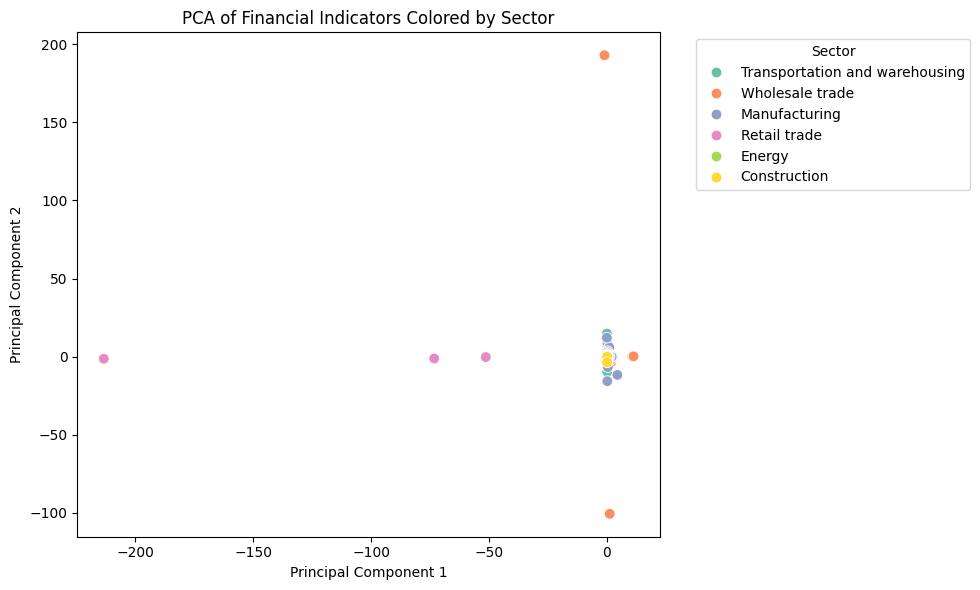

In [16]:
feature_cols = [col for col in df_all.columns if col.startswith("X")]

X = df_all[feature_cols]
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_all["PC1"], df_all["PC2"] = components[:, 0], components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x="PC1", y="PC2", hue="sector_name", palette="Set2", s=60)
plt.title("PCA of Financial Indicators Colored by Sector")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.11277077 0.10268767]


<Axes: xlabel='PC1', ylabel='PC2'>

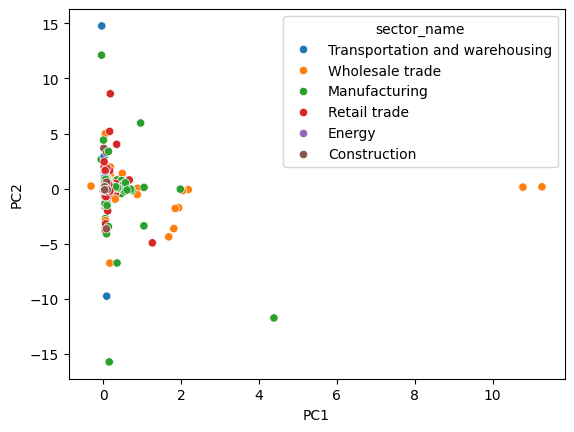

In [18]:
# TEMPORARY filter for PCA outliers (visual clarity)
df_filtered = df_all[(df_all["PC1"].between(-50, 50)) & (df_all["PC2"].between(-50, 50))]
sns.scatterplot(data=df_filtered, x="PC1", y="PC2", hue="sector_name")


<Axes: xlabel='PC1', ylabel='PC2'>

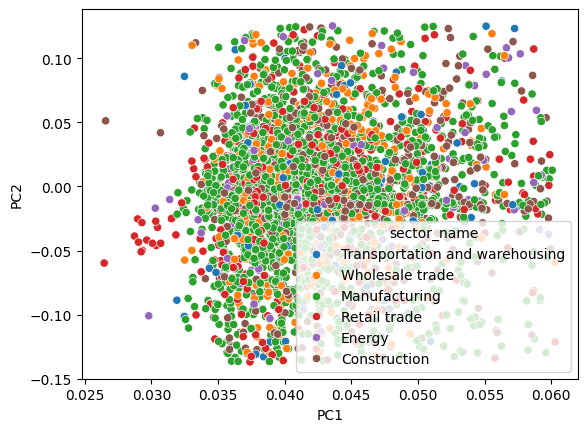

In [19]:
Q1 = df_all[["PC1", "PC2"]].quantile(0.25)
Q3 = df_all[["PC1", "PC2"]].quantile(0.75)
IQR = Q3 - Q1
bounds = (df_all[["PC1", "PC2"]] >= (Q1 - 1.5 * IQR)) & (df_all[["PC1", "PC2"]] <= (Q3 + 1.5 * IQR))
df_filtered_Q = df_all[bounds.all(axis=1)]
sns.scatterplot(data=df_filtered_Q, x="PC1", y="PC2", hue="sector_name")

### Correlation Heatmap

In [20]:
# Select financial indicator columns
feature_cols = [col for col in df_all.columns if col.startswith("X")]

# Compute correlation matrix and get absolute correlations with S
correlations = df_all[feature_cols + ["S"]].corr()
top_10_corr = correlations["S"].drop("S").sort_values(key=abs, ascending=False).head(10)


# Display results
print("🔝 Top 10 features most correlated with sector (S):\n")
for feature, corr in top_10_corr.items():
    print(f"{feature:<5} → correlation: {corr:.4f}")


🔝 Top 10 features most correlated with sector (S):

X24   → correlation: 0.1358
X44   → correlation: 0.0702
X7    → correlation: -0.0409
X15   → correlation: -0.0408
X71   → correlation: 0.0331
X37   → correlation: -0.0311
X40   → correlation: -0.0309
X25   → correlation: 0.0280
X4    → correlation: -0.0268
X36   → correlation: 0.0261


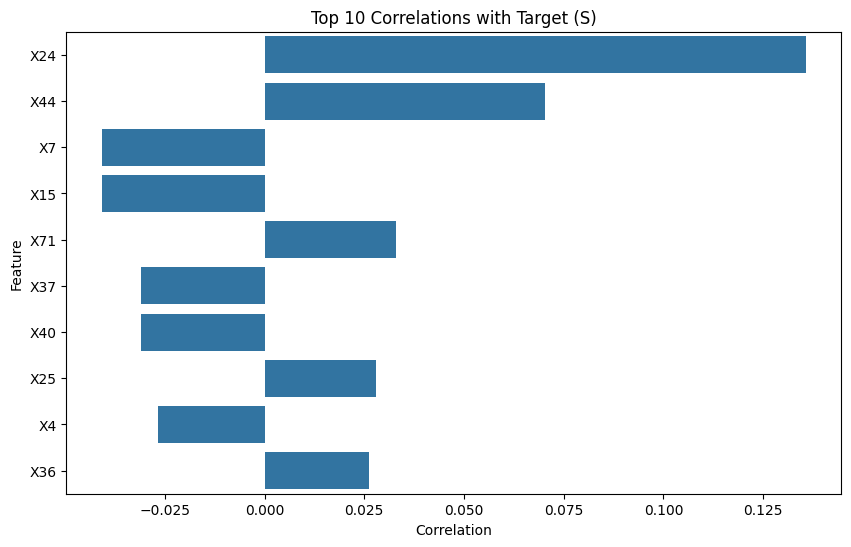

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index)
plt.title("Top 10 Correlations with Target (S)")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

In [22]:
sector_nan_count = df_all['S'].isna().sum()

print("before", sector_nan_count)

df_all.dropna(subset=['S'], inplace=True)

sector_nan_count = df_all['S'].isna().sum()
print("after", sector_nan_count)


before 8
after 0


In [23]:
df_all.to_csv("combined_data.csv", index=False)

### Plots 

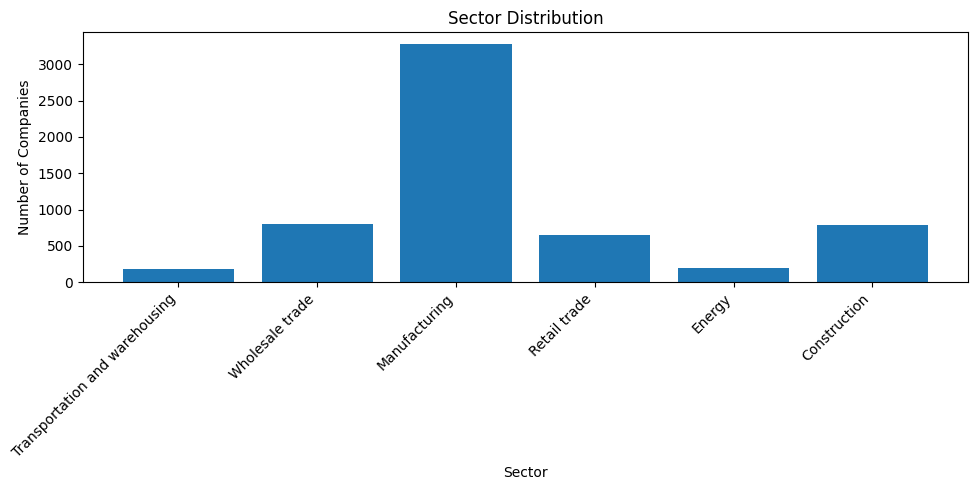

In [24]:
# Count sector frequencies and map to names
sector_counts = df_all["S"].value_counts().sort_index()
sector_names = [sector_map.get(s, f"Unknown ({s})") for s in sector_counts.index]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(sector_names, sector_counts.values)
plt.title("Sector Distribution")
plt.xlabel("Sector")
plt.ylabel("Number of Companies")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

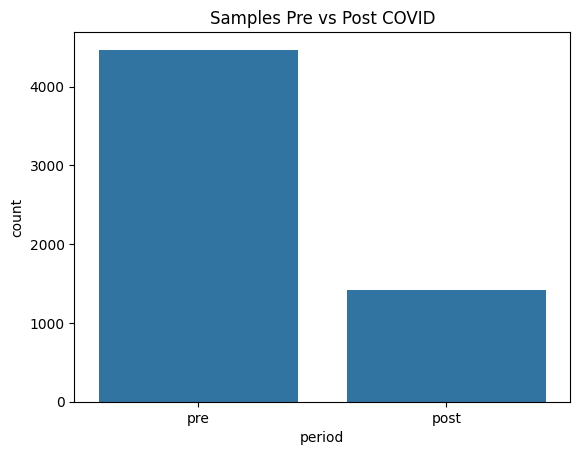

In [25]:
# Pre vs Post COVID
sns.countplot(data=df_all, x="period")
plt.title("Samples Pre vs Post COVID")
plt.show()


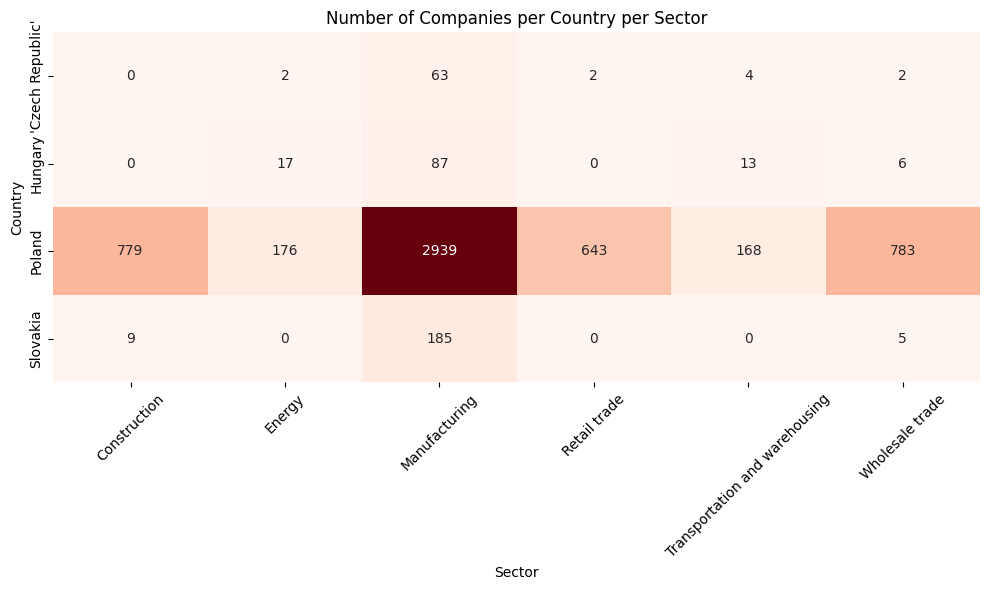

In [26]:
# Plot a heatmap showing the number of companies per country and sector
country_sector_counts = pd.crosstab(df_all["Country"], df_all["sector_name"])

plt.figure(figsize=(10, 6))
sns.heatmap(country_sector_counts, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Number of Companies per Country per Sector")
plt.xlabel("Sector")
plt.ylabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task One

### Pre vs Post COVID

In [27]:
def anova_feature_test(df: pd.DataFrame, feature: str, group_col: str = "period") -> dict | None:
    """Runs ANOVA for a feature across two groups defined in group_col."""
    groups = df[group_col].dropna().unique()
    if len(groups) != 2:
        return None  # We expect only two groups for standard ANOVA

    group1, group2 = groups
    values1 = df[df[group_col] == group1][feature].dropna()
    values2 = df[df[group_col] == group2][feature].dropna()

    if len(values1) > 1 and len(values2) > 1:
        stat, p = f_oneway(values1, values2)
        return {"feature": feature, "F_statistic": stat, "p_value": p}
    return None


In [30]:
df_all = pd.read_csv("combined_data.csv")

results = [
    res for col in feature_cols
    if (res := anova_feature_test(df_all, col)) is not None
]
anova_df_sorted = pd.DataFrame(results).sort_values("p_value")
display(anova_df_sorted.head(10))

/Users/mori/Personal/0.Code/4.Verona Project/env_verona/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,feature,F_statistic,p_value
23,X24,9.4993,0.0021
52,X53,7.4890,0.0062
67,X68,5.6240,0.0177
43,X44,4.2309,0.0397
32,X33,3.2382,0.0720
51,X52,3.1646,0.0753
80,X81,3.1525,0.0759
24,X25,2.8778,0.0899
6,X7,2.8006,0.0943
14,X15,2.7730,0.0959


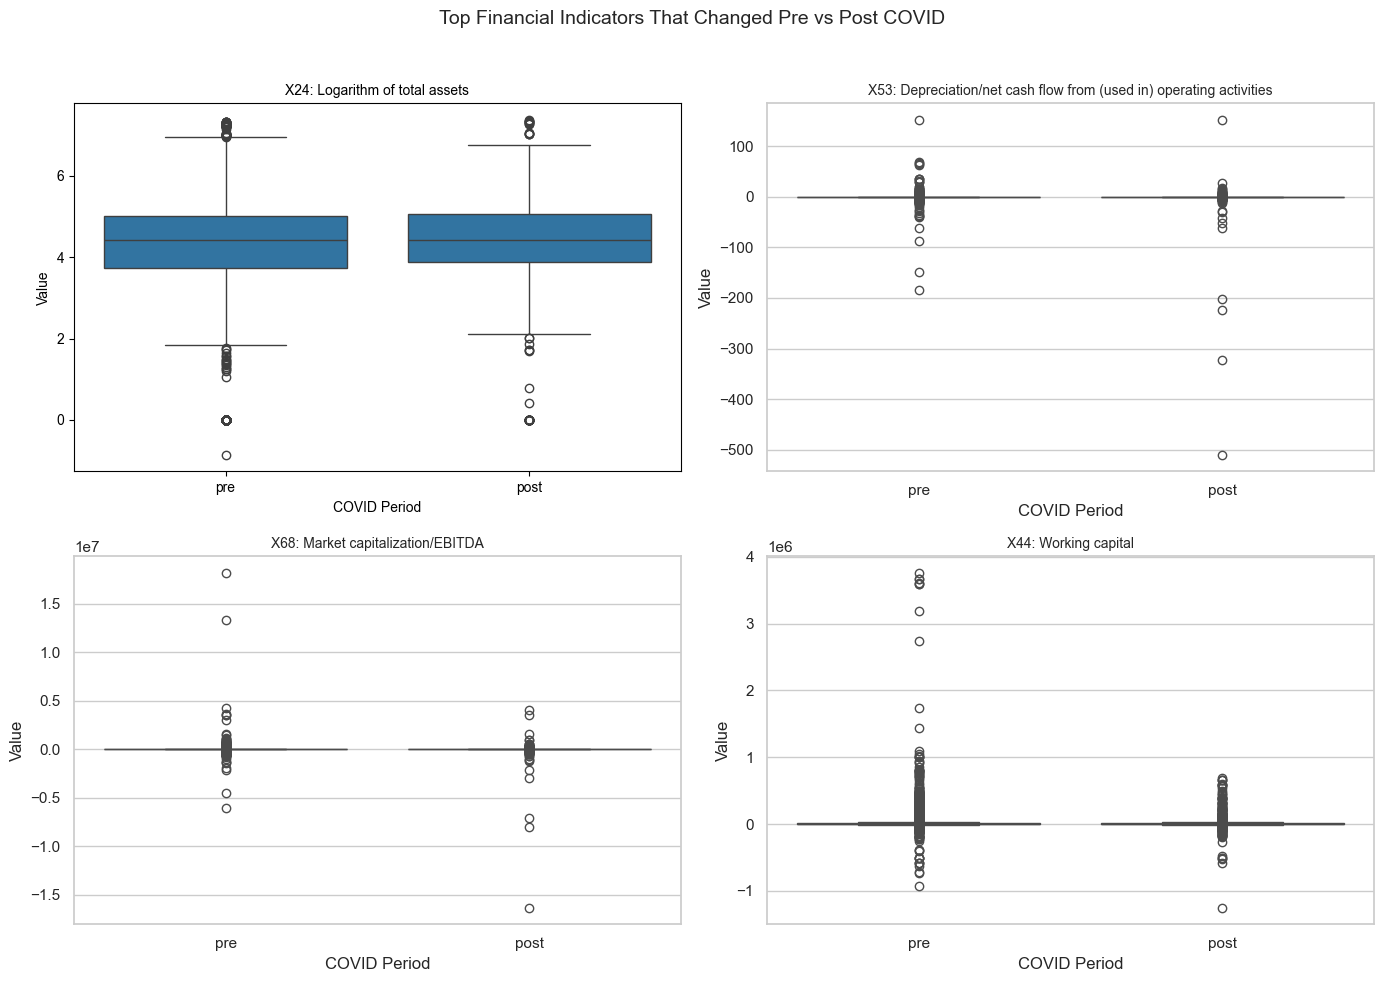

In [31]:
# Extract features with significant p-values
top_features = anova_df_sorted[anova_df_sorted["p_value"] < 0.05]["feature"].tolist()
top_5_features = anova_df_sorted.head(5)["feature"].tolist()

# === 2. Load the dimension file and clean it
dimension_path = "data_challenge/dimension/dimension.csv"

# The file has semicolon-separated values in a single column
dim_df = pd.read_csv(dimension_path, header=None)
dim_df = dim_df[dim_df.columns[0]].str.split(";", expand=True)
dim_df.columns = dim_df.iloc[0]
dim_df = dim_df[1:]  # Remove the header row
dim_df["Variable Name"] = dim_df["Variable Name"].str.strip()

# === 3. Create a lookup dictionary for descriptions
description_map = dict(zip(dim_df["Variable Name"], dim_df["Description"]))

# === 4. Plot each feature
plt.figure(figsize=(14, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 2, i)
    sns.set_theme(style="whitegrid")
    sns.boxplot(data=df_all, x="period", y=feature)
    plt.title(f"{feature}: {description_map.get(feature, 'No description')}", fontsize=10)
    plt.xlabel("COVID Period")
    plt.ylabel("Value")

plt.suptitle("Top Financial Indicators That Changed Pre vs Post COVID", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### By Sector

In [32]:
df_all = pd.read_csv("combined_data.csv")

# Define financial indicator columns
feature_cols = [col for col in df_all.columns if col.startswith("X")]

# Dictionary to store significant features per sector
sector_significant_features = {}

# Loop through each unique sector
for sector in df_all["S"].dropna().unique():
    sector_df = df_all[df_all["S"] == sector]
    significant_features = []

    for feature in feature_cols:
        # Extract pre and post COVID values
        pre_vals = sector_df[sector_df["period"] == "pre"][feature].dropna()
        post_vals = sector_df[sector_df["period"] == "post"][feature].dropna()


        f_stat, p_val = f_oneway(pre_vals, post_vals)
        if p_val < 0.05:
                significant_features.append({
                    "feature": feature,
                    "F_statistic": f_stat,
                    "p_value": p_val
                })
    significant_features.sort(key=lambda x: x["p_value"])
    sector_significant_features[sector] = significant_features

# Count how many sectors each feature was significant in
feature_counts = Counter(
    feat["feature"] for features in sector_significant_features.values() for feat in features
)

# Convert to DataFrame and sort descending
feature_rank_df = pd.DataFrame(
    feature_counts.items(), columns=["feature", "num_sectors"]
).sort_values(by="num_sectors", ascending=False)


# Display the result
display(feature_rank_df)


/Users/mori/Personal/0.Code/4.Verona Project/env_verona/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,feature,num_sectors
4,X68,2
5,X24,2
9,X33,2
13,X71,2
0,X44,1
12,X42,1
19,X64,1
18,X5,1
17,X20,1
16,X34,1


In [33]:
# Flatten it into a list of rows
rows = []
for sector, feature_list in sector_significant_features.items():
    for entry in feature_list:
        rows.append({
            "sector": int(sector),
            "feature": entry["feature"],
            "F_statistic": float(entry["F_statistic"]),
            "p_value": float(entry["p_value"]),
        })

# Convert to DataFrame
anova_sector_df = pd.DataFrame(rows)

# Display the result
display(anova_sector_df)

,sector,feature,F_statistic,p_value
0,1,X44,8.9806,0.0031
1,1,X53,5.2277,0.0234
2,1,X69,4.6441,0.0325
3,1,X75,4.3220,0.0390
4,2,X68,4.4129,0.0360
5,3,X24,5.1238,0.0237
6,3,X14,4.8656,0.0275
7,3,X68,4.4205,0.0356
8,3,X21,3.9397,0.0472
9,4,X67,5.5139,0.0192


/var/folders/hy/mk_vwbtj60795d_nf8959q2c0000gn/T/ipykernel_61587/3217606393.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hy/mk_vwbtj60795d_nf8959q2c0000gn/T/ipykernel_61587/3217606393.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/mori/Personal/0.Code/4.Verona Project/env_verona/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


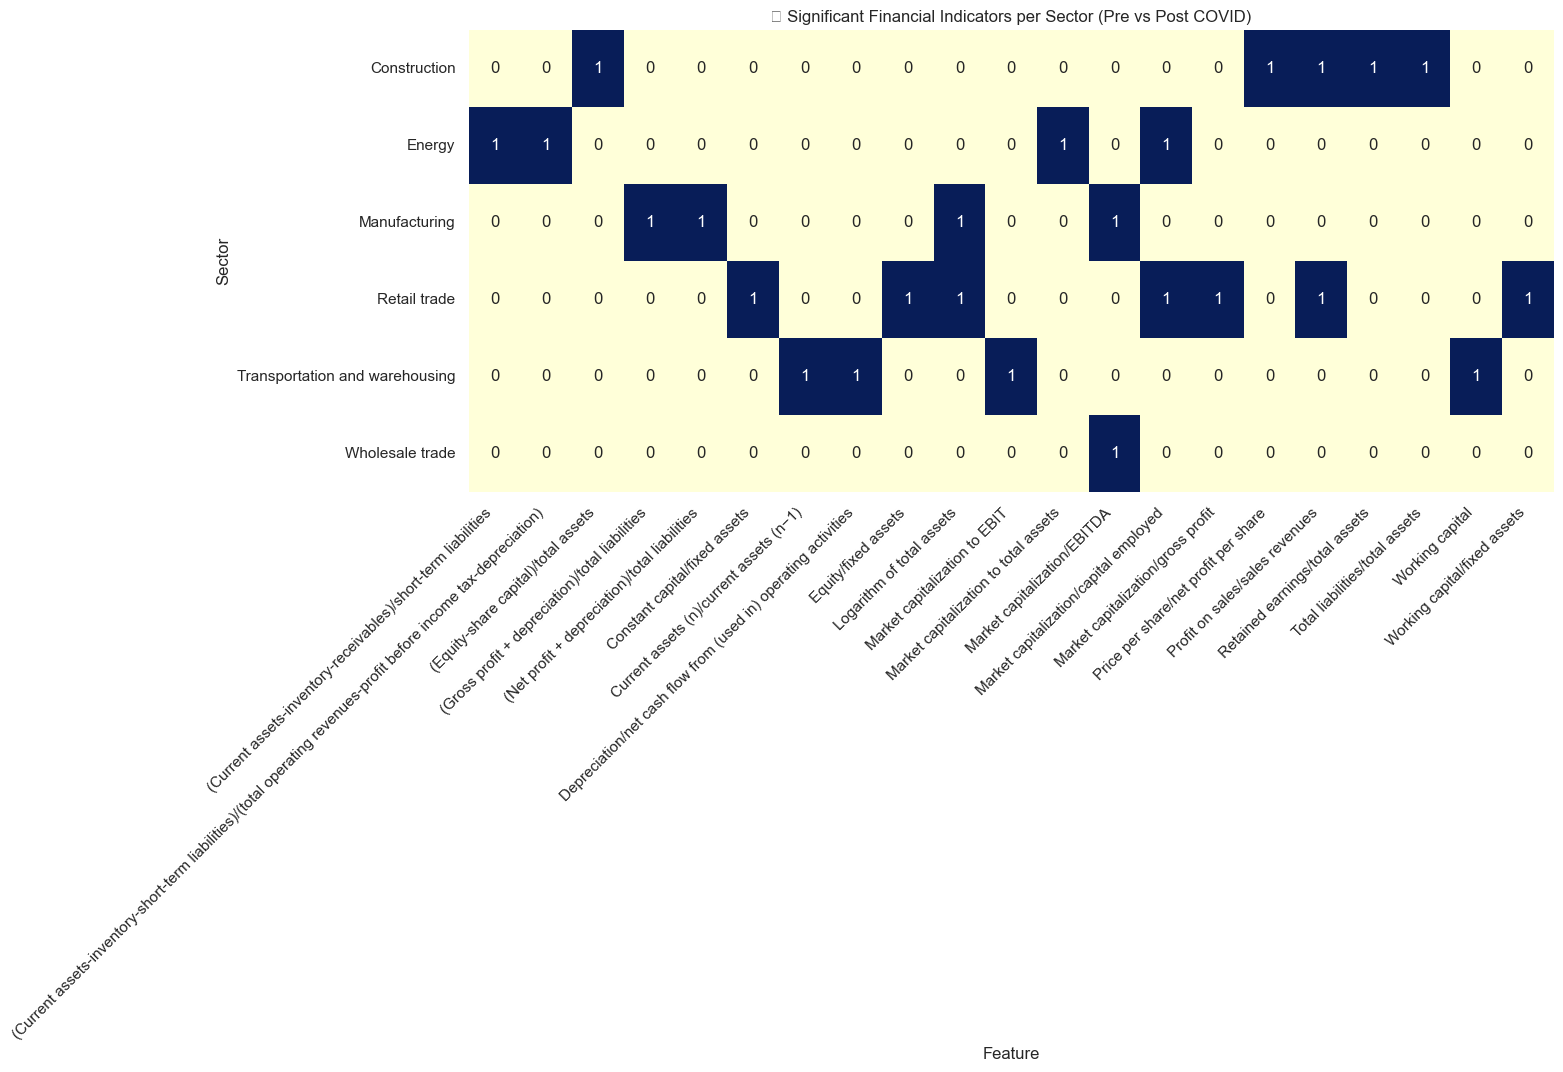

In [34]:
# Use sector names directly from df_all
sector_code_to_name = df_all[["S", "sector_name"]].drop_duplicates().set_index("S")["sector_name"].to_dict()

# Load financial feature descriptions
dim_df = pd.read_csv("data_challenge/dimension/dimension.csv")  # Update path
dim_df = dim_df[dim_df.columns[0]].str.split(";", expand=True)
dim_df.columns = ["Variable Name", "Role", "Type", "Demographic", "Description", "Units", "Missing Values"]
feature_map = dict(zip(dim_df["Variable Name"].str.strip(), dim_df["Description"].str.strip()))

# Build records (sector name and feature description)
records = []
for sector_code, features in sector_significant_features.items():
    sector_name = sector_code_to_name.get(sector_code, f"Sector {int(sector_code)}")
    for feat in features:
        feat_label = feature_map.get(feat["feature"], feat["feature"])
        records.append((sector_name, feat_label))

df_map = pd.DataFrame(records, columns=["Sector", "Feature"])

# Pivot table for heatmap
pivot = pd.crosstab(df_map["Sector"], df_map["Feature"])

# Plot
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("📊 Significant Financial Indicators per Sector (Pre vs Post COVID)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 Sector 1 — Plotting 4 feature(s)


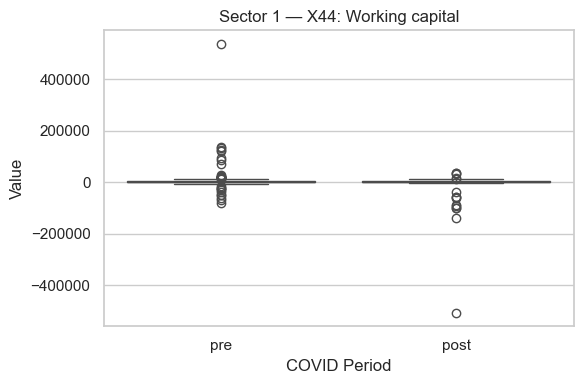

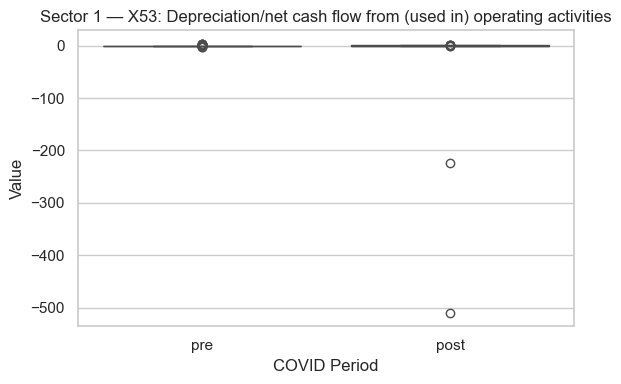

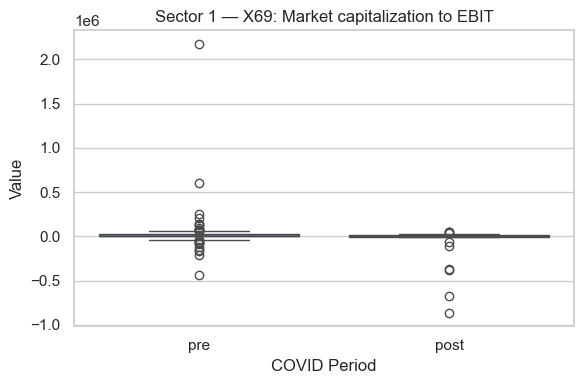

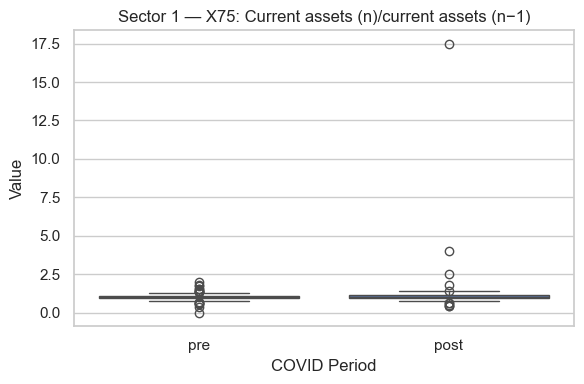

📊 Sector 2 — Plotting 1 feature(s)


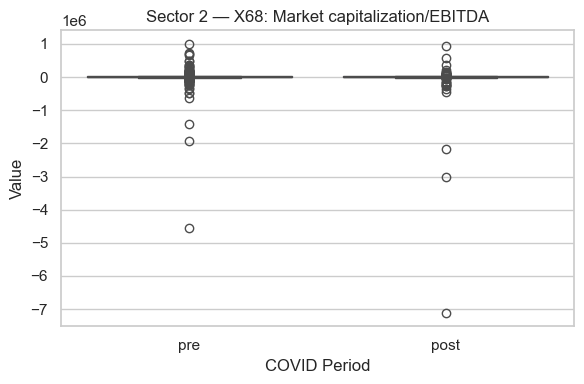

📊 Sector 3 — Plotting 4 feature(s)


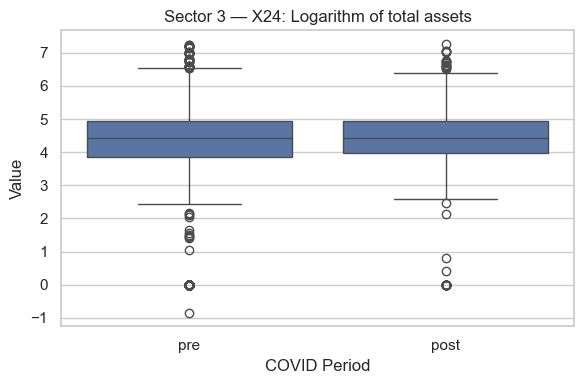

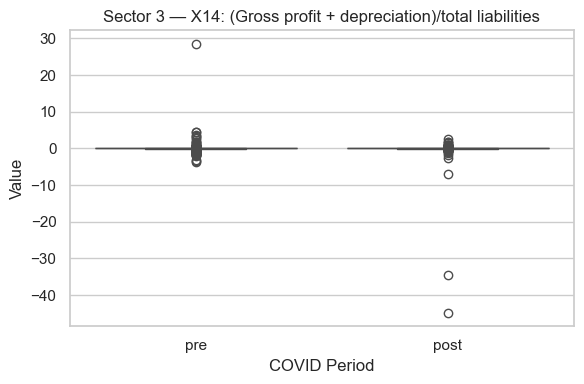

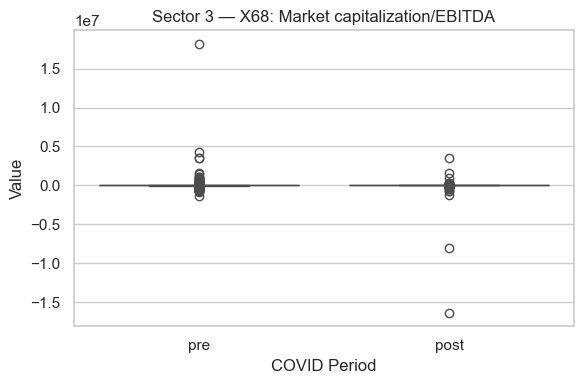

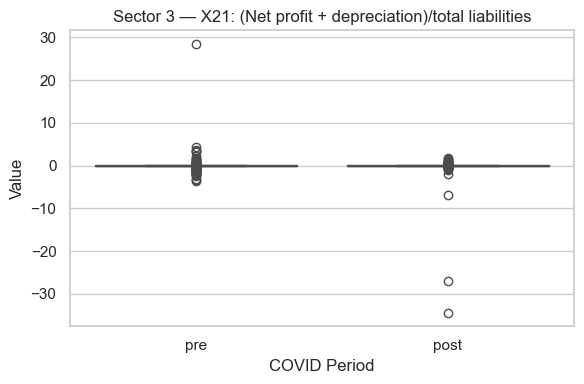

📊 Sector 4 — Plotting 7 feature(s)


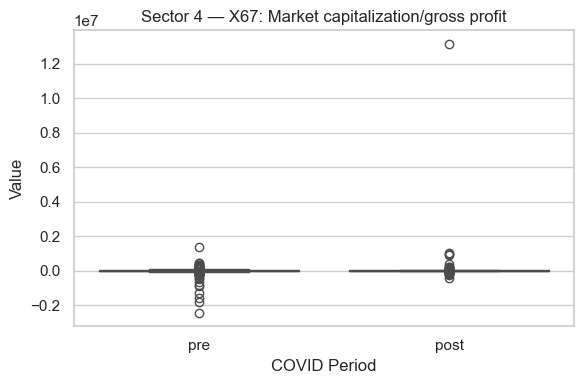

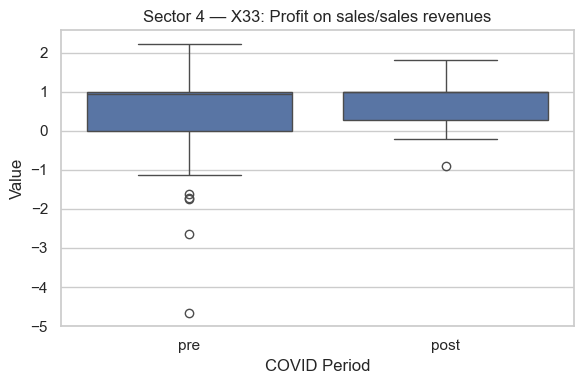

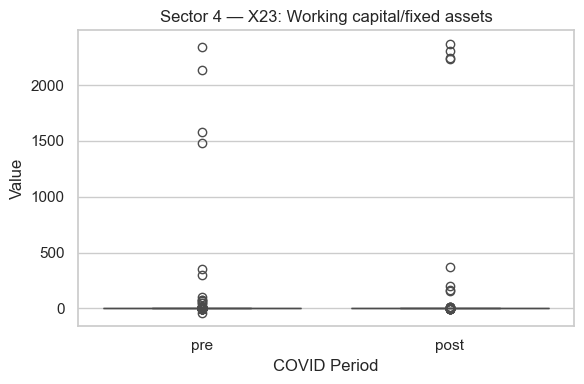

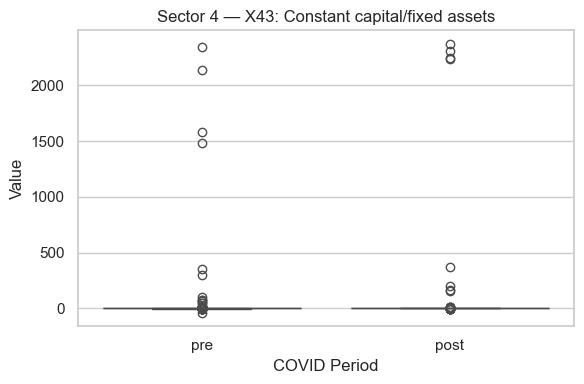

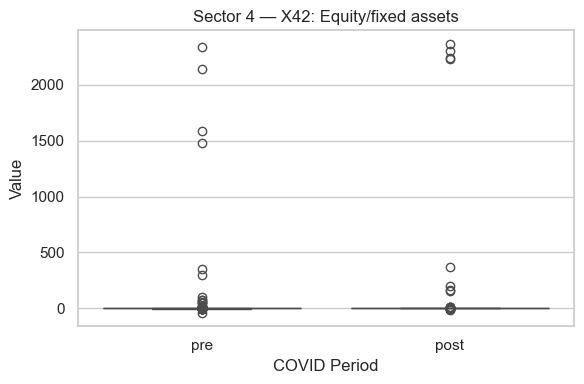

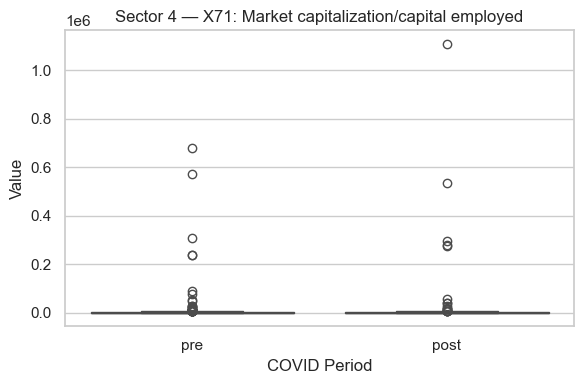

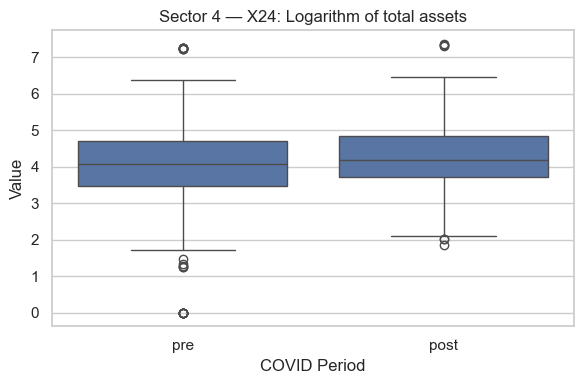

📊 Sector 5 — Plotting 4 feature(s)


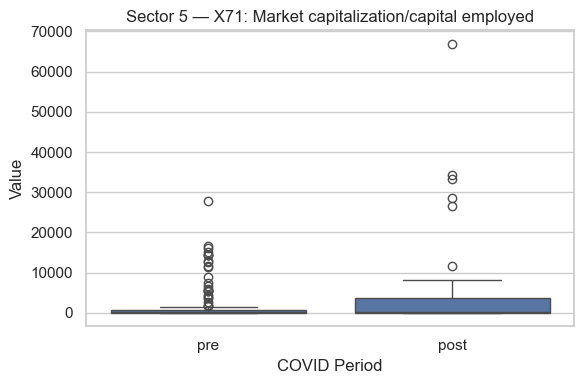

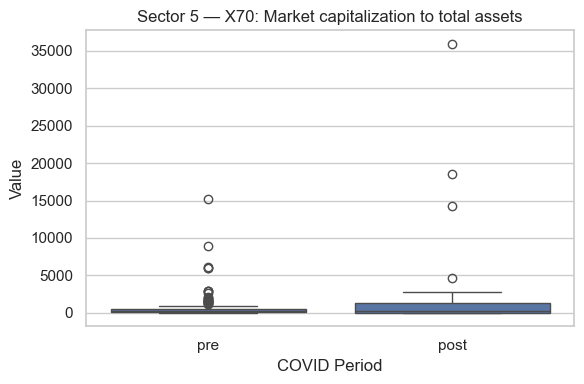

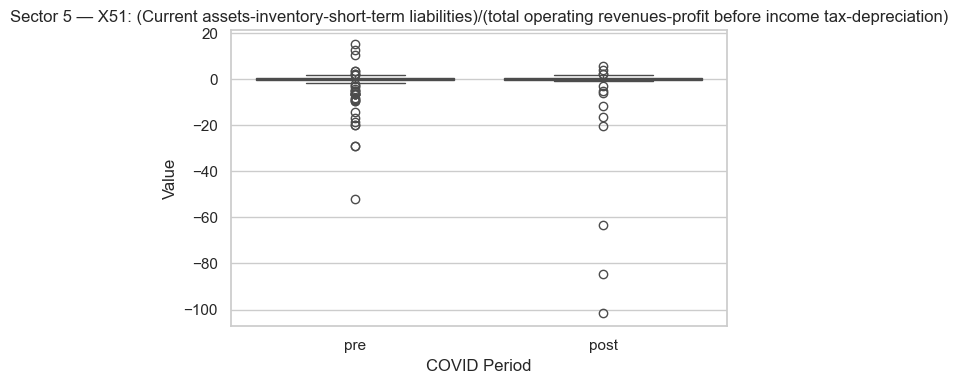

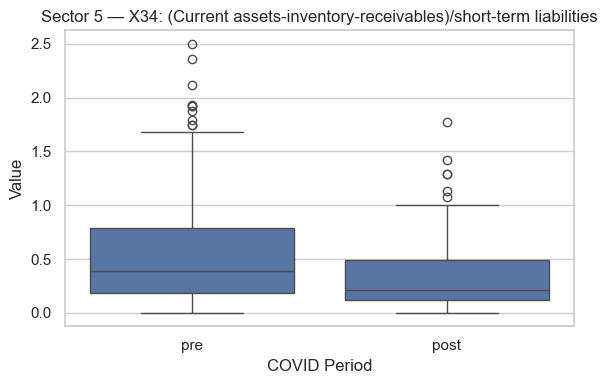

📊 Sector 6 — Plotting 5 feature(s)


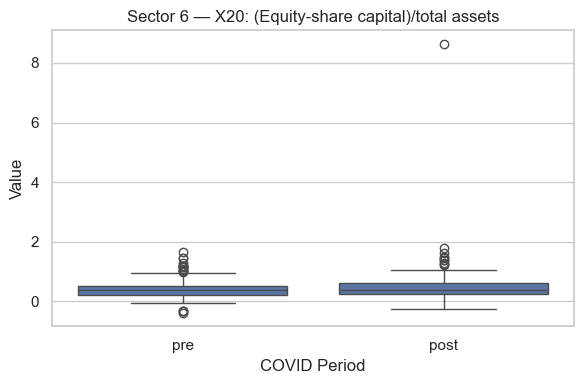

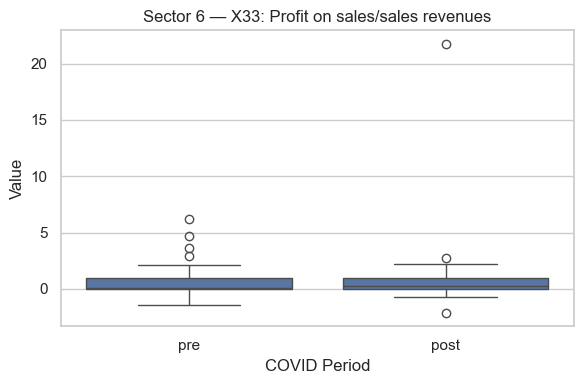

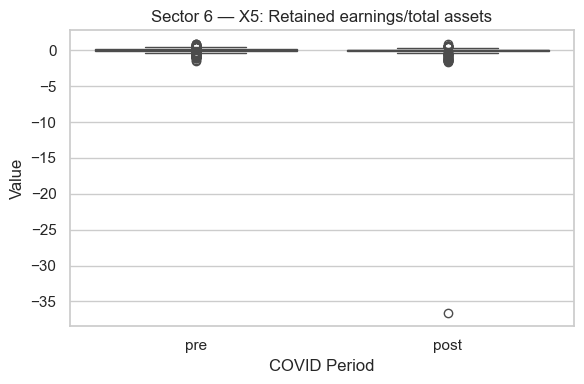

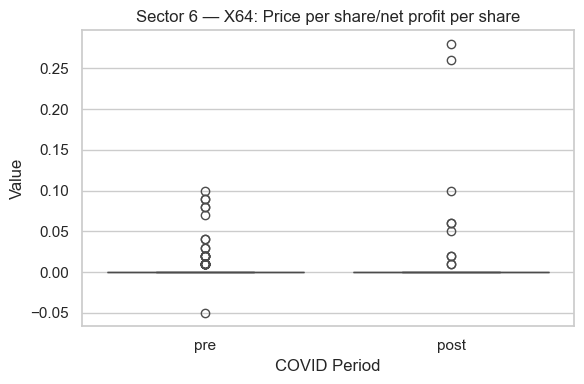

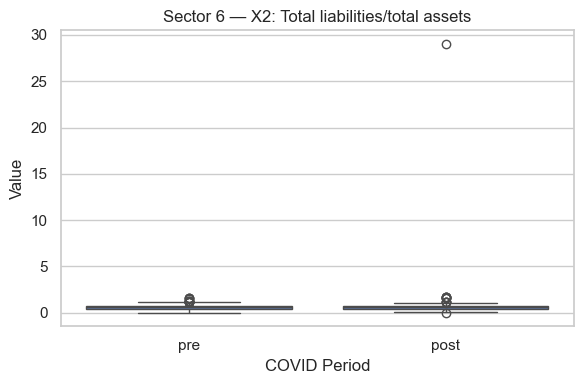

In [35]:
# Loop through each sector and its significant features
for sector_code, features in sector_significant_features.items():
    sector_df = df_all[df_all["S"] == sector_code]

    # Skip sectors with no matching data
    if sector_df.empty:
        continue

    print(f"📊 Sector {int(sector_code)} — Plotting {len(features)} feature(s)")

    # Plot boxplot for each changed feature
    for feature in features:
        if feature["feature"] not in sector_df.columns:
            continue

        plt.figure(figsize=(6, 4))
        sns.set_theme(style="whitegrid")
        sns.boxplot(data=sector_df, x="period", y=feature["feature"])
        description = feature_map.get(feature["feature"], "")
        plt.title(f"Sector {int(sector_code)} — {feature['feature']}: {description}")
        plt.xlabel("COVID Period")
        plt.ylabel("Value")
        plt.tight_layout()
        
        plt.show()


# Take Two

### Data Preparation

In [54]:
df_all = pd.read_csv("combined_data.csv")
display(df_all.head())

,Country,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,S,year,quarter,period,sector_name,PC1,PC2
0,Poland,0.0000,0.4900,0.0600,1.3100,0.0600,0.0100,1.0600,0.1800,0.5100,0.0100,0.0500,0.0500,0.0400,0.0200,2.0600,0.0100,0.0500,0.0100,0.0200,0.4600,0.0100,2.6900,0.0700,6.2300,2.4800,0.0100,0.9600,0.3500,0.0000,0.1800,0.6900,0.8200,0.0000,0.6100,0.0400,0.1500,1.1900,0.0300,0.1600,0.4800,0.1800,0.6700,1.0700,"94,440.1300",0.0100,0.6000,8.5100,1.6800,0.9800,0.2300,0.2000,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,829.6200,"46,173.1900","15,221.7400","68,156.1700",426.1700,555.8400,1.1200,1.0900,1.0600,1.0400,13.7000,-14.8800,1.1100,1.1200,1.0400,0.0000,0.5900,1,2017,2,pre,Transportation and warehousing,0.0427,0.0033
1,Hungary,0.0100,0.7800,-0.0400,0.9000,0.0000,0.0100,0.2700,0.2700,0.2200,0.0100,0.0200,0.0300,-0.8100,0.0100,1.2700,0.0200,0.0300,0.0100,0.0200,0.2200,0.0100,-4.2400,-0.0600,5.8100,2.6400,0.0600,-0.0300,-0.0200,0.0000,0.0000,0.8400,0.6200,0.0000,0.3900,0.0500,0.9400,0.8900,0.0300,0.1300,0.4400,0.3800,0.3300,0.9400,"-23,622.8500",0.0200,1.8800,47.5800,1.4300,0.7100,0.4100,4.5300,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0500,-0.0500,1.1500,1.1900,1.4500,0.9200,1.1400,1.0800,1.1800,0.0000,0.0000,1,2017,2,pre,Transportation and warehousing,0.0391,-0.1458
2,Poland,-0.0200,0.4400,0.1800,1.5200,0.2800,-0.0100,1.2900,0.2100,0.5600,-0.0200,-0.0200,-0.0400,-0.0700,-0.0200,2.2900,-0.0400,-0.0400,-0.0200,-0.0900,0.2800,-0.0400,-1.8000,0.3900,4.9700,1.7600,-0.0300,0.6700,0.5300,0.0000,0.2100,4.7400,0.6500,0.0000,0.2200,-0.0900,-0.1600,1.1700,-0.0100,-0.0500,1.2200,0.3500,1.2100,1.3900,"16,981.8200",-0.0300,0.1500,1.6900,0.6200,0.5900,0.4400,0.2700,-0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,"1,199.5500","-89,163.8800","-60,401.1200","-37,722.9700",675.9800,"1,446.0100",2.3400,2.0400,0.7300,0.5700,0.7400,0.8900,1.6000,0.6000,0.4800,0.0000,0.7300,1,2017,2,pre,Transportation and warehousing,0.0426,-0.0447
3,Poland,0.0000,0.6400,0.1400,1.2300,-0.0200,0.0100,0.5600,0.9000,0.3600,0.0100,0.0200,0.0100,0.0100,0.0200,1.5600,0.0100,0.0100,0.0100,0.0000,0.3700,0.0000,1.5600,0.5900,4.1600,0.7200,0.0200,1.4500,1.3800,0.1000,0.9000,27.0700,0.3800,0.1100,0.2400,0.0100,0.0800,1.1800,0.0000,0.0000,1.1800,0.6200,1.4800,1.5900,"2,060.0000",0.0100,0.0800,30.1400,1.5400,1.4600,3.6900,0.1300,-0.1300,0.0000,-0.0200,-0.0200,-0.0300,-0.6600,-0.0300,4.9000,-0.0200,-2.3600,0.0000,0.0000,0.0000,0.0000,652.8300,"17,942.3700","8,448.2050","30,880.9900",233.7300,964.0200,1.1500,1.1600,1.0300,1.0200,0.6300,0.6900,0.4200,1.0900,1.0000,-0.3600,-0.0700,1,2017,2,pre,Transportation and warehousing,0.0425,0.0005
4,Poland,0.0100,0.5400,0.0800,1.2000,0.0300,0.0200,0.8600,0.3400,0.4600,0.0200,0.0400,0.0500,0.0400,0.0300,1.8600,0.0300,0.0500,0.0100,0.0300,0.4300,0.0200,9.7600,0.1600,4.3500,1.5900,0.0300,0.8400,0.6400,0.3400,0.3600,2.9900,0.5900,1.0000,0.0300,0.0400,0.0900,0.9600,0.0300,0.0900,0.9100,0.4100,0.9100,1.1600,"1,854.0000",0.0200,0.2800,3.3700,0.8900,0.8300,0.6600,-0.0500,1.1400,0.0000,0.0100,0.0200,0.0100,0.0600,0.0200,-4.9200,0.0200,0.5300,0.0000,0.0000,0.0000,0.0000,951.7300,"25,860.0000","13,858.4700","30,653.2500",439.3400,862.5800,1.1500,1.2100,1.2000,1.3400,0.7600,0.4800,1.3200,1.3700,1.3200,5.6100,-1.9000,1,2017,2,pre,Transportation and warehousing,0.0398,-0.0067


In [46]:
y = df_all["S"]

In [58]:
# Separate categorical and numerical features
categorical_features = ["Country", "year", "quarter", "period"]
numerical_features = [col for col in df_all.columns if col.startswith("X")]

In [59]:
X_all_num_cat = df_all[numerical_features + categorical_features]
X_all_num = df_all[[col for col in df_all.columns if col.startswith("X")]]

In [60]:
significant_features = set()
for feats in sector_significant_features.values():
    for feat in feats:
        significant_features.add(feat["feature"])

X_selected_num_cat = df_all[list(significant_features) + categorical_features]
X_selected_num = df_all[list(significant_features)]


In [61]:
X_train_all_num_cat, X_test_all_num_cat, y_train_all, y_test_all = train_test_split(
    X_all_num_cat, y, test_size=0.2, stratify=y, random_state=42
)
X_train_all_num, X_test_all_num, y_train_all, y_test_all = train_test_split(
    X_all_num, y, test_size=0.2, stratify=y, random_state=42
)

X_train_selected_num_cat, X_test_selected_num_cat, y_train_selected, y_test_selected = train_test_split(
    X_selected_num_cat, y, test_size=0.2, stratify=y, random_state=42
)

X_train_selected_num, X_test_selected_num, y_train_selected, y_test_selected = train_test_split(
    X_selected_num, y, test_size=0.2, stratify=y, random_state=42
)

### Model Selecting

*** Basic Training on All Features ***

In [63]:
# Preprocessing: scale numeric, encode categorical
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [90]:
# Pipeline: preprocessing + model
clf_pipeline_all_num_cat = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Cross-validation
cv_all_num_cat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_all_num_cat = cross_val_score(clf_pipeline_all_num_cat, X_train_all_num_cat, y_train_all, cv=cv_all_num_cat, scoring="f1_macro")

# Results
print("✅ Cross-validation F1 Macro Scores:", scores_all_num_cat)
print("📊 Mean F1 Macro: {:.3f} ± {:.3f}".format(scores_all_num_cat.mean(), scores_all_num_cat.std()))

✅ Cross-validation F1 Macro Scores: [0.70552972 0.72816174 0.73813548 0.71692508 0.76816497]
📊 Mean F1 Macro: 0.731 ± 0.021


In [91]:
""" Cross Validation usage for estimating how well your model is likely to perform on unseen data """
# --- Initialize model for all features ---
clf_all_num_cv = RandomForestClassifier(n_estimators=100, random_state=42)

# --- Cross-validation ---
cv_all_num = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_all_cv_num = cross_val_score(clf_all_num_cv, X_train_all_num, y_train_all, cv=cv_all_num, scoring="f1_macro")

# --- Print results ---
print("✅ Cross-validation F1 Macro Scores:", scores_all_cv_num)
print("📊 Mean F1 Macro: {:.3f} ± {:.3f}".format(scores_all_cv_num.mean(), scores_all_cv_num.std()))

✅ Cross-validation F1 Macro Scores: [0.70003193 0.73634059 0.73780128 0.74149222 0.75937264]
📊 Mean F1 Macro: 0.735 ± 0.019


In [89]:
# Model training and evaluation with all features
clf_all_num = RandomForestClassifier(n_estimators=100, random_state=42)
clf_all_num.fit(X_train_all_num, y_train_all)
y_pred_all_num = clf_all_num.predict(X_test_all_num)
print(classification_report(y_test_all, y_pred_all_num))


              precision    recall  f1-score   support

           1       0.96      0.68      0.79        37
           2       0.80      0.62      0.70       159
           3       0.78      0.95      0.86       655
           4       0.91      0.53      0.67       129
           5       1.00      0.44      0.61        39
           6       0.88      0.78      0.83       158

    accuracy                           0.81      1177
   macro avg       0.89      0.66      0.74      1177
weighted avg       0.83      0.81      0.80      1177



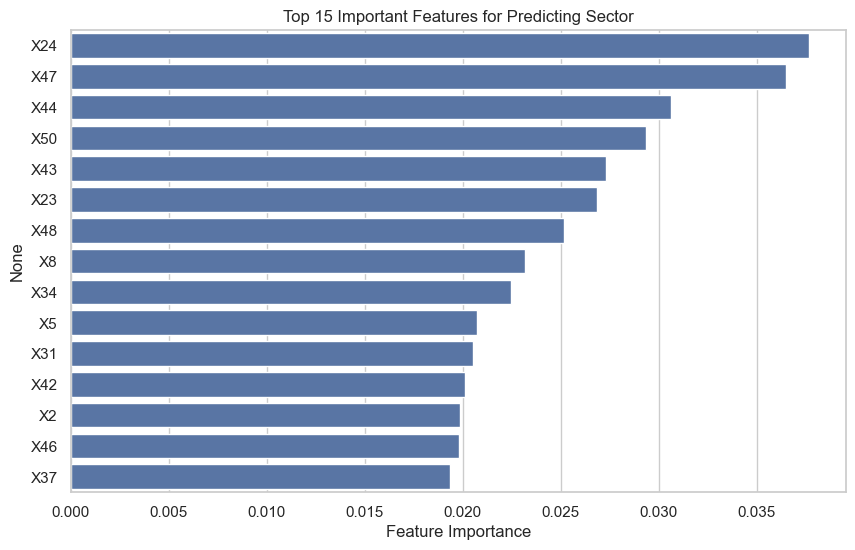

In [74]:
# Plot feature importances for all features to pick some top ones to re-train the model
importances = pd.Series(clf_all_num_cv.feature_importances_, index=X_all.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Important Features for Predicting Sector")
plt.xlabel("Feature Importance")
plt.show()


*** Basic Training on Selected Features ***

In [97]:
# Preprocessing: scale numeric, encode categorical
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(significant_features)),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [98]:
# Pipeline: preprocessing + model selected features
clf_pipeline_selected_num_cat = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Cross-validation
cv_selected_num_cat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_selected_num_cat = cross_val_score(clf_pipeline_selected_num_cat, X_train_selected_num_cat, y_train_selected, cv=cv_selected_num_cat, scoring="f1_macro")

# Results
print("✅ Cross-validation F1 Macro Scores:", scores_selected_num_cat)
print("📊 Mean F1 Macro: {:.3f} ± {:.3f}".format(scores_selected_num_cat.mean(), scores_selected_num_cat.std()))

✅ Cross-validation F1 Macro Scores: [0.65901725 0.71359582 0.73384313 0.71207825 0.72203981]
📊 Mean F1 Macro: 0.708 ± 0.026


In [101]:
""" Cross Validation usage for estimating how well your model is likely to perform on unseen data """

# --- Initialize model for selected features ---
clf_selected_num_cv = RandomForestClassifier(n_estimators=100, random_state=42)

# --- Cross-validation ---
cv_selected_num = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_selected_cv_num = cross_val_score(clf_selected_num_cv, X_train_selected_num, y_train_selected, cv=cv_selected_num, scoring="f1_macro")

# --- Print results ---
print("✅ Cross-validation F1 Macro Scores:", scores_selected_cv_num)
print("📊 Mean F1 Macro: {:.3f} ± {:.3f}".format(scores_selected_cv_num.mean(), scores_selected_cv_num.std()))

✅ Cross-validation F1 Macro Scores: [0.68792862 0.73258337 0.73505485 0.71699715 0.77186064]
📊 Mean F1 Macro: 0.729 ± 0.027


In [102]:
# Model training and evaluation with selected features as feature selection method
clf_selected_num = RandomForestClassifier(n_estimators=100, random_state=42) 
clf_selected_num.fit(X_train_selected_num, y_train_selected)    
y_pred_selected_num = clf_selected_num.predict(X_test_selected_num)
print(classification_report(y_test_selected, y_pred_selected_num))

              precision    recall  f1-score   support

           1       0.88      0.59      0.71        37
           2       0.83      0.65      0.73       159
           3       0.78      0.96      0.86       655
           4       0.92      0.42      0.57       129
           5       0.67      0.46      0.55        39
           6       0.89      0.78      0.84       158

    accuracy                           0.81      1177
   macro avg       0.83      0.64      0.71      1177
weighted avg       0.82      0.81      0.79      1177



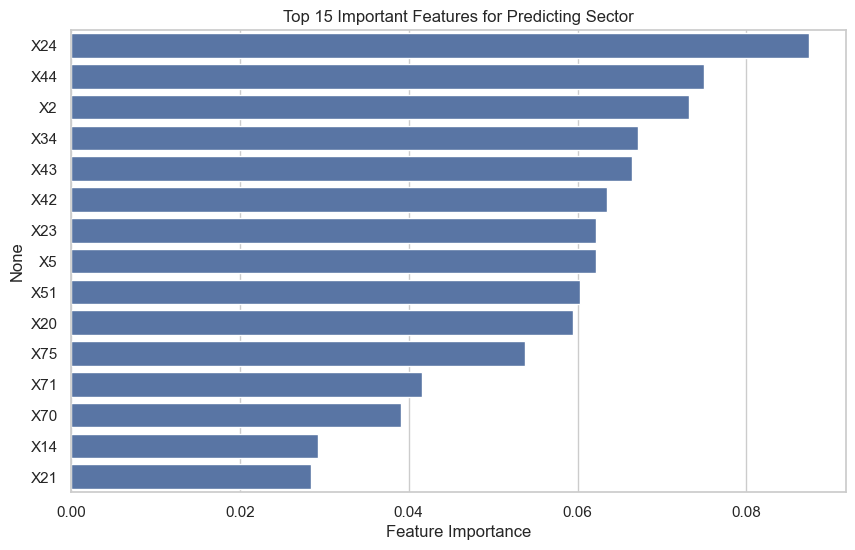

In [103]:
# Plot feature importances for selected features to pick some top ones to re-train the model
importances = pd.Series(clf_selected_num.feature_importances_, index=X_selected.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Important Features for Predicting Sector")
plt.xlabel("Feature Importance")
plt.show()


*** Grid Search Method for Hyper-Parameter Tuning with CV ***

In [104]:
# --- Define the model for all features ---
clf_all_GS = RandomForestClassifier(random_state=42)

# --- Define parameter grid ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# --- Define cross-validation ---
cv_all_GS = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid search with F1 macro scoring ---
grid_search_all_GS = GridSearchCV(
    estimator=clf_all_GS,
    param_grid=param_grid,
    cv=cv_all_GS,
    scoring='f1_macro',
    n_jobs=-1,  # Use all cores
    verbose=2   # Progress output
)

# --- Fit the search ---  
grid_search_all_GS.fit(X_train_all_num, y_train_all)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.1s
[CV] END m

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=2)

In [105]:
# --- Best results ---
print("✅ Best F1_macro score: {:.3f}".format(grid_search_all_GS.best_score_))
print("🏆 Best parameters:", grid_search_all_GS.best_params_)

✅ Best F1_macro score: 0.751
🏆 Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [106]:
best_model_all_GS = grid_search_all_GS.best_estimator_
y_pred_all_GS = best_model_all_GS.predict(X_test_all)

print(classification_report(y_test_all, y_pred_all_GS))


              precision    recall  f1-score   support

           1       0.96      0.65      0.77        37
           2       0.82      0.62      0.71       159
           3       0.79      0.96      0.86       655
           4       0.90      0.53      0.67       129
           5       0.90      0.46      0.61        39
           6       0.87      0.79      0.83       158

    accuracy                           0.82      1177
   macro avg       0.87      0.67      0.74      1177
weighted avg       0.83      0.82      0.81      1177



In [107]:
# --- Define the model for selected features ---
clf_selected_GS = RandomForestClassifier(random_state=42)

# --- Define parameter grid ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# --- Define cross-validation ---
cv_selected_GS = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Grid search with F1 macro scoring ---
grid_search_selected_GS = GridSearchCV(
    estimator=clf_selected_GS,
    param_grid=param_grid,
    cv=cv_all_GS,
    scoring='f1_macro',
    n_jobs=-1,  # Use all cores
    verbose=2   # Progress output
)

# --- Fit the search ---  
grid_search_selected_GS.fit(X_train_selected_num, y_train_selected)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END m

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=2)

In [108]:
# --- Best results ---
print("✅ Best F1_macro score: {:.3f}".format(grid_search_selected_GS.best_score_))
print("🏆 Best parameters:", grid_search_selected_GS.best_params_)

✅ Best F1_macro score: 0.729
🏆 Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [109]:
best_model_selected_GS = grid_search_selected_GS.best_estimator_
y_pred_selected_GS = best_model_selected_GS.predict(X_test_selected)

print(classification_report(y_test_selected, y_pred_selected_GS))

              precision    recall  f1-score   support

           1       0.88      0.59      0.71        37
           2       0.83      0.65      0.73       159
           3       0.78      0.96      0.86       655
           4       0.92      0.42      0.57       129
           5       0.67      0.46      0.55        39
           6       0.89      0.78      0.84       158

    accuracy                           0.81      1177
   macro avg       0.83      0.64      0.71      1177
weighted avg       0.82      0.81      0.79      1177

